# Matrix-friendly modeling with gurobipy

In [ ]:
# Install gurobipy as needed
%pip install "gurobipy>=10.0"

# Install other dependencies
%pip install numpy
%pip install scipy
%pip install gurobipy
%pip install pandas

Please Note: This notebook uses features from Gurobi 10.0, please ensure this is the version you are using.  To upgrade, please visit our [Download Center](https://www.gurobi.com/downloads/) and [Quick Start Guide](https://www.gurobi.com/documentation/quickstart.html)

# Term based vs. matrix based notation and thinking

## A linear function

$ c = [c_j] \in \mathbf{R}^n $ data, $ x = [x_j] \in \mathbf{R}^n $ variable
- Term based: $ \sum_{j=1}^n c_j x_j $
- Matrix based: $ c^T x $

## A quadratic function

Symmetric $ Q = [q_{ij}] \in \mathbf{R}^{n, n} $ data, $ x = [x_j] \in \mathbf{R}^n $ variable


- Term based: $ \sum_{i,j} q_{ij} x_i x_j $
- Matrix based: $ x^T Q x $
    

## System of linear equations

$ A = [a_{ij}] \in \mathbf{R}^{m, n} $ data, $ x = [x_j] \in \mathbf{R}^n $ variable

- Term based: $ \sum_{j=1}^n a_{ij} x_j = b_i, \quad i=1, \dotsc, m $
- Matrix based: $ Ax = b $

## gurobipy's matrix-friendly modeling API

- Enables natural model building using matrix based expressions
- Complements existing capabilities for term-based modeling
- Concepts and semantics lean on NumPy


In [1]:
import math
import numpy as np
import scipy.sparse as sp
import gurobipy as gp
import pandas as pd
gp.setParam('OutputFlag', 0)

## Example: Nonnegative regression

Consider $ A \in \mathbf{R}^{m,n}, b \in \mathbf{R}^m $ (typically $ m \ge n $).  We want to solve:

$$
\min_{x \ge 0} \|b - Ax\|_2^2\\
$$

One possible optimization model:

- Variable $ x \in \mathbf{R}^n $ (regression weights)
- Variable $ r \in \mathbf{R}^m $ (residual)
- Data $ b \in \mathbf{R}^m $

Equivalent formulation:
$$
\begin{align}
\min_{x, r} \; & r^T r\\
\mbox{s.t.} \; & r = b - Ax\\
& x \ge 0
\end{align}
$$



$$
\begin{align}
\min_{x, r} \; & r^T r\\
\mbox{s.t.} \; & r = b - Ax\\
& x \ge 0
\end{align}
$$

In [2]:
# Example data
A = np.random.rand(100, 10)
b = A @ np.random.rand(10) + 0.01 * np.random.rand(100)

model = gp.Model()
x = model.addMVar(10, name="x")
r = model.addMVar(100, lb=-np.inf, name="r")
model.setObjective(r @ r)
model.addConstr(r == b - A @ x)
model.optimize()
print(f"Regression values: {x.X}")
print(f"Fit error: {math.sqrt(r.X @ r.X):.2e}")


Regression values: [0.62331363 0.67830492 0.45668578 0.94078157 0.47761859 0.33563749
 0.30552197 0.83604204 0.59606945 0.98501313]
Fit error: 2.86e-02


Let's dissect this line-by-line
```
x = model.addMVar(10)
r = model.addMVar(100, lb=-np.inf)
```

This adds two "matrix variables" to the model, `x` comprises 10 variables, `r` 100.

In [3]:
# MVar objects share some properties with NumPy ndarrays
print("Basic x properties...")
print(x.shape)
print(x.ndim)
print(x.size)
print("Basic r properties...")
print(r.shape)
print(r.ndim)
print(r.size)


Basic x properties...
(10,)
1
10
Basic r properties...
(100,)
1
100


In [4]:
# MVar's can be indexed and sliced "as usual"
print(x[0])
print()
print(x[:4])
print()
print(x[np.newaxis, [3, 6, 1], np.newaxis])

<MVar ()>
array(<gurobi.Var x[0] (value 0.6233136323600569)>)

<MVar (4,)>
array([<gurobi.Var x[0] (value 0.6233136323600569)>,
       <gurobi.Var x[1] (value 0.6783049177680529)>,
       <gurobi.Var x[2] (value 0.45668577939554045)>,
       <gurobi.Var x[3] (value 0.9407815748206986)>])

<MVar (1, 3, 1)>
array([[[<gurobi.Var x[3] (value 0.9407815748206986)>],
        [<gurobi.Var x[6] (value 0.3055219685947518)>],
        [<gurobi.Var x[1] (value 0.6783049177680529)>]]])


In [5]:
# We can query "the usual" Gurobi variable attributes, yields ndarray
print("Basic x properties...")
print(x.lb)
print(x.ub)
print(x.obj)
print("Basic r properties...")
print(r.lb[:15])
print(r.ub[:15])
print(r.obj[:15])

Basic x properties...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[inf inf inf inf inf inf inf inf inf inf]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Basic r properties...
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf]
[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


```
model.setObjective(r @ r)
```

Inner product $ r^T r $ is set to be the objective function.  

In [6]:
# r @ r is an MQuadExpr object. 
print(r @ r)

<MQuadExpr ()  >
array( 0.0 + [ r[0] ^ 2 + r[1] ^ 2 + r[2] ^ 2 + r[3] ^ 2 + r[4] ^ 2 + r[5] ^ 2 + r[6] ^ 2 + r[7] ^ 2 + r[8] ^ 2 + r[9] ^ 2 + r[10] ^ 2 + r[11] ^ 2 + r[12] ^ 2 + r[13] ^ 2 + r[14] ^ 2 + r[15] ^ 2 + r[16] ^ 2 + r[17] ^ 2 + r[18] ^ 2 + r[19] ^ 2 + r[20] ^ 2 + r[21] ^ 2 + r[22] ^ 2 + r[23] ^ 2 + r[24] ^ 2 + r[25] ^ 2 + r[26] ^ 2 + r[27] ^ 2 + r[28] ^ 2 + r[29] ^ 2 + r[30] ^ 2 + r[31] ^ 2 + r[32] ^ 2 + r[33] ^ 2 + r[34] ^ 2 + r[35] ^ 2 + r[36] ^ 2 + r[37] ^ 2 + r[38] ^ 2 + r[39] ^ 2 + r[40] ^ 2 + r[41] ^ 2 + r[42] ^ 2 + r[43] ^ 2 + r[44] ^ 2 + r[45] ^ 2 + r[46] ^ 2 + r[47] ^ 2 + r[48] ^ 2 + r[49] ^ 2 + r[50] ^ 2 + r[51] ^ 2 + r[52] ^ 2 + r[53] ^ 2 + r[54] ^ 2 + r[55] ^ 2 + r[56] ^ 2 + r[57] ^ 2 + r[58] ^ 2 + r[59] ^ 2 + r[60] ^ 2 + r[61] ^ 2 + r[62] ^ 2 + r[63] ^ 2 + r[64] ^ 2 + r[65] ^ 2 + r[66] ^ 2 + r[67] ^ 2 + r[68] ^ 2 + r[69] ^ 2 + r[70] ^ 2 + r[71] ^ 2 + r[72] ^ 2 + r[73] ^ 2 + r[74] ^ 2 + r[75] ^ 2 + r[76] ^ 2 + r[77] ^ 2 + r[78] ^ 2 + r[79] ^ 2 + r[80] ^ 2 + r[81] 

In [7]:
# It is an ndarray-like object, too
print((r @ r).shape)  # Remember: r.shape was (100,)
print((r @ r).ndim)
print((r @ r).size)

()
0
1


```
model.addConstr(r == b - A @ x)
```
Ties residual and regression variables together.  Focus on `b - A @ x`...

In [8]:
# b - A @ x is an MLinExpr
print(b - A @ x)

<MLinExpr (100,)  >
array([ 3.766024116156394 + -0.7137547825434497 x[0] + -0.9972110185272416 x[1] + -0.13433464467279654 x[2] + -0.4123963412798669 x[3] + -0.18722737420741387 x[4] + -0.5885153924434304 x[5] + -0.3429429829704862 x[6] + -0.9335463259104873 x[7] + -0.31780175085411444 x[8] + -0.8443812730616349 x[9],
        2.7646101329123662 + -0.8277646954809661 x[0] + -0.2906619816738727 x[1] + -0.2027624893944474 x[2] + -0.1052033334782031 x[3] + -0.39304298787690084 x[4] + -0.9877061539061611 x[5] + -0.3038949737385428 x[6] + -0.4704734374085786 x[7] + -0.5474763212659519 x[8] + -0.533957851460142 x[9],
        3.6397532281471228 + -0.5332680136429749 x[0] + -0.37194591823620926 x[1] + -0.7194914311712657 x[2] + -0.7293312612877312 x[3] + -0.8179704063888278 x[4] + -0.45258997265726575 x[5] + -0.41740885246506665 x[6] + -0.3499507279205284 x[7] + -0.15142183693576672 x[8] + -0.9991210228908073 x[9],
        2.769722987174457 + -0.06676277324939972 x[0] + -0.8506431822082672 x[1]

In [9]:
# Again ndarray-like...
print((b - A @ x).shape)
print((b - A @ x).ndim)
print((b - A @ x).size)

(100,)
1
100


In [10]:
# You can index, slice it...
print((b - A @ x)[5:7])

<MLinExpr (2,)>
array([ 2.047021392812091 + -0.29942506407048275 x[0] + -0.2367722759708153 x[1] + -0.0001497061662173449 x[2] + -0.43879007688219407 x[3] + -0.619893002908066 x[4] + -0.7868223843647609 x[5] + -0.11068083234792836 x[6] + -0.027094061307127215 x[7] + -0.8036392760981275 x[8] + -0.19397372415852043 x[9],
        2.950395775839056 + -0.5419869603750004 x[0] + -0.563700228582126 x[1] + -0.4048954853365939 x[2] + -0.5917731235157758 x[3] + -0.5154285543940638 x[4] + -0.14727976900751627 x[5] + -0.22651208359134123 x[6] + -0.5026401510600887 x[7] + -0.45527328846288095 x[8] + -0.4342526442784992 x[9]])


## Example: Sparse minimum variance portfolio

- Goal: Allocate at most $ k $ out of $ n $ assets such that estimated risk is minimal
- $ x_i $: Relative allocation in asset $ i $
- $ b_i $ : Binary variable constrolling whether asset $ i $ is traded

$$
\begin{align}
\min_{x,b} \;  x^T S x \; \mbox{s.t} \; & \sum_i x_i = 1\\
& \sum_i b_i \le k\\
& x \le b\\
& 0 \le x \le 1\\
& b \in \{0,1\}^n
\end{align}
$$

In [11]:
stockdata = {'AA': {0: -0.000601195612674, 1: 0.0191767846723, 2: -0.0203332000076, 3: 0.0014206991819, 4: 0.00864771267018, 5: 0.00577363510133, 6: 0.0432486801673, 7: 0.00035530109459, 8: 0.0113584690751, 9: 0.00751644560006, 10: -0.0141644967957, 11: 0.00451033311878, 12: -0.000528830057118, 13: 0.00574272738462, 14: 0.000775603728123, 15: 0.0246643410379, 16: -0.00236028993862, 17: -0.0244476331116, 18: -0.00262488262575, 19: -0.00584594063823, 20: 0.0120799513092, 21: -0.020868708632, 22: 0.0135951629031, 23: -0.0111132130847, 24: -0.033788224374, 25: 0.0226370121649, 26: 0.0235649770703, 27: 0.0209361014708, 28: -0.0246475821594, 29: -0.0134395887063, 30: -0.0398247997375, 31: 0.0253270508986, 32: 0.0093313079267, 33: 0.00153938656825, 34: 0.0111782073623, 35: -0.026555628498, 36: -0.00416041668116, 37: -0.00491300387844, 38: -0.00582526334303, 39: 0.00853871777087, 40: -0.0131241509519, 41: -0.0123746045878, 42: 0.00810593335715, 43: -0.00478016363034, 44: -0.000401536690365, 45: -0.0112471669918, 46: -0.00785199112119, 47: -0.00958020726683, 48: -0.0220780015871, 49: 0.0012261223914, 50: 0.0136953369744, 51: -0.0117470373079, 52: -0.013734117216, 53: 0.000859516200072, 54: 0.0124719768086, 55: -0.00146477712014, 56: -0.0128089665896, 57: 0.00427496666572, 58: 0.00949545564434, 59: -0.00365653550232, 60: 0.0220336600873, 61: 0.0155483358961, 62: 0.00203394198923, 63: 0.0113945250886, 64: 0.0225828454549, 65: 0.00433855331562, 66: -0.0177159182143, 67: -0.00669847476031, 68: -0.0145258965669, 69: -0.00679443904448, 70: 0.0173185959116, 71: -0.00231367057888, 72: 0.0222481043686, 73: -0.0165712798179, 74: 0.00776075560668, 75: 0.00192141744359, 76: -0.00463731336859, 77: 0.0426106702311, 78: 0.0215648952904, 79: 0.0136757135077, 80: 0.00617965807988, 81: 0.00827057057041, 82: -0.0171304476187, 83: 0.0150852508966, 84: -0.00234317814202, 85: -0.00469100415108, 86: 0.00194209898258, 87: 0.00852593205056, 88: 0.0276521115285, 89: 0.0133737485075, 90: -0.00464066765461, 91: -0.00958514018475, 92: -0.0154444194986, 93: 0.00791224522103, 94: 0.00637331209611, 95: 0.00674563449838, 96: -0.0141545458531, 97: 0.000565614545811, 98: 0.0140224246204, 99: -0.0161839108359, 100: 0.0132959473637, 101: -0.0147997501425, 102: 0.0260224473089, 103: 0.0285873703369, 104: 0.0118011001579, 105: 0.0404444423477, 106: 0.0234588363246, 107: 0.0247077067434, 108: 0.000332739447088, 109: -0.0175121144217, 110: -0.0138621958466, 111: -0.0179554948684, 112: 0.00240279195468, 113: -0.0133935015991, 114: 0.00912224311037, 115: -0.0252338676178, 116: 0.00121702001279, 117: 0.0128834747226, 118: 0.00710385478522, 119: 0.0126322227916, 120: 0.00470140388013, 121: 0.0211568308866, 122: 0.0135429933148, 123: -0.0148444436435, 124: -0.00460503704601, 125: -0.00239004983426, 126: -0.00114206615915, 127: 0.00918699125778, 128: -0.0211450840091, 129: -0.00896314067088, 130: -0.00154800983195, 131: 0.0542198475254, 132: 0.0173518293389, 133: -0.00376410694025, 134: 0.00632100975764, 135: -0.00532772320458, 136: -0.0347948456692, 137: -0.0104662120037, 138: -0.0273051255595, 139: -0.0221161909248, 140: 0.00418905187179, 141: -0.0236076028009, 142: -0.0205146281898, 143: 0.0298754453007, 144: 0.0111108311173, 145: -0.00322019024633, 146: -0.0095033894911, 147: -0.00212868262627, 148: 0.00608044804716, 149: 0.0148614484821, 150: 0.00577278965602, 151: 0.0126775352319, 152: -0.0328624258456, 153: 0.0139185620933, 154: -0.00039115069619, 155: -0.0143811196387, 156: 0.0132930096865, 157: 0.0067545713289, 158: -0.00340809812086, 159: 0.00355914243332, 160: 0.0116085864156, 161: 0.00221973797975, 162: -0.00026950914781, 163: -0.00106675272985, 164: 0.0231768057235, 165: 0.0085337374003, 166: 0.0176780687168, 167: -0.000368228915606, 168: -0.0201044827462, 169: -0.00485700569954, 170: -0.0243154868025, 171: 0.000133675662093, 172: 0.00391238934562, 173: 0.0164955582883, 174: -0.0201018496478, 175: -0.007599291757, 176: 0.0010710903635, 177: 0.0211933230501, 178: -0.0141682453933, 179: 0.00585145661042, 180: -0.00660621913102, 181: 0.0123861135249, 182: -0.00364226064724, 183: -0.0070074869175, 184: -0.0361174564225, 185: 0.0100567524958, 186: 0.00100830894276, 187: 0.00892758378887, 188: -0.00320632839208, 189: -0.0194864691591, 190: -0.0034446340564, 191: 0.0304089247227, 192: 0.0178173969118, 193: -0.0150592743175, 194: 0.0314829174754, 195: 0.0191291688885, 196: 0.00757981131026, 197: 0.00484717534986, 198: -0.000543567669053, 199: 0.0145716930581, 200: 0.0288463228085, 201: -0.0164155590184, 202: 0.0110636113386, 203: -0.0167077695946, 204: -0.00894342431824, 205: 0.0219841025144, 206: -0.00849773464514, 207: 0.0245302693108, 208: -0.00875822478818, 209: 0.00775446871564, 210: 0.00963494468183, 211: -0.0292138621687, 212: -0.0169999810475, 213: 0.014238833919, 214: 0.0187092695557, 215: 0.0244388979793, 216: -0.00325325053934, 217: 0.00368985906995, 218: -0.0277954571427, 219: -0.00021448703465, 220: 0.00565125198602, 221: -0.0166940242661, 222: -0.00819664098315, 223: 0.0159342249515, 224: -0.014968719135, 225: 0.0115603852315, 226: 0.00104053759548, 227: 0.00366379466702, 228: 0.0242293332232, 229: -0.0162536710595, 230: 0.00699898290742, 231: 0.0275565451779, 232: -0.00314920406065, 233: -0.0184657147251, 234: 0.0124055180811, 235: 0.00795511492544, 236: 0.0302956302386, 237: 0.0438419499379, 238: -0.0117595370238, 239: -0.00383556484179, 240: 0.00738202668306, 241: -0.00336166301819, 242: 0.00435908156545, 243: -0.0184016736973, 244: -0.0162371774179}, 'BB': {0: 0.00235338594971, 1: 0.0500080797498, 2: 0.0266382125763, 3: -0.0538128052695, 4: 0.114835959861, 5: 0.0146318448214, 6: 0.0908105558426, 7: 0.0560587804076, 8: 0.0100309028542, 9: 0.106341791652, 10: 0.0119751707846, 11: -0.0193238647214, 12: -0.0710183734529, 13: 0.0222947634929, 14: 0.0663566202073, 15: 0.0588993602597, 16: 0.0690374542955, 17: -0.0586158832898, 18: 0.0580227606829, 19: 0.0351716906205, 20: 0.0155573850289, 21: -0.0155255559646, 22: 0.0302550139619, 23: 0.150177550604, 24: 0.0078483728137, 25: -0.00971287247341, 26: -0.0884683361872, 27: 0.0871100040442, 28: 0.0552670826116, 29: -0.0270182008736, 30: -0.054404384123, 31: 0.0836083820024, 32: -0.00333779725378, 33: 0.00761990815315, 34: -0.0555158122222, 35: -0.043944730246, 36: 0.0113994807744, 37: 0.0004925489191, 38: -0.0569862851559, 39: 0.0360837829527, 40: -0.0647138168666, 41: 0.0934671112935, 42: -0.0288208281307, 43: 0.0121194767053, 44: -0.0102517455577, 45: 0.0231274677052, 46: 0.0336057853269, 47: -0.00796078100473, 48: -0.00730156059547, 49: 0.0417298226881, 50: 0.0405732305449, 51: -0.0369734598884, 52: 0.0266817916815, 53: -0.0033925247879, 54: 0.0283409504649, 55: 0.0372280401709, 56: -0.0452010658715, 57: -0.047706601455, 58: 0.0282158599398, 59: -0.0245872635602, 60: -0.0555772480231, 61: 0.0685224796302, 62: -0.0149803621042, 63: -0.0157103147662, 64: 0.104800696848, 65: -0.0224656847887, 66: 0.032152100147, 67: 0.0436781932292, 68: -0.00666905010122, 69: -0.0428472993431, 70: -0.0810431495283, 71: -0.0155309228638, 72: 0.105614930363, 73: -0.00466231551591, 74: -0.0676099557089, 75: -0.0181088903712, 76: -0.0243540590881, 77: -0.014590616484, 78: 0.017358170343, 79: -0.00886009893898, 80: 0.0391553746241, 81: -0.0406268574783, 82: -0.0774606497046, 83: 0.0488717328487, 84: -0.131000826976, 85: -0.0372411975932, 86: 0.0922130485918, 87: 0.0283145537587, 88: 0.0573597802546, 89: 0.0356613644229, 90: 0.0905187369886, 91: -0.0419536836106, 92: -0.00463812455342, 93: 0.0589577670721, 94: -0.0454962770709, 95: 0.0444804439167, 96: 0.00657094547191, 97: 0.0663893347746, 98: 0.0430606717283, 99: -0.0548710508816, 100: 0.0338044725341, 101: 0.0437752946042, 102: -0.00238749660454, 103: -0.00307137213223, 104: -0.0196070158158, 105: -0.0329211125393, 106: 0.0253452971005, 107: 0.0605220788793, 108: 0.147248936319, 109: -0.0142125718255, 110: -0.0880030345748, 111: 0.0147998202055, 112: 0.032770899666, 113: 0.0812547709933, 114: -0.0132939255915, 115: 0.00300935099355, 116: 0.0982069083595, 117: -0.116963246124, 118: 0.00469208071947, 119: 0.0685522824773, 120: 0.0542290174718, 121: 0.0206487766194, 122: -0.0247595481416, 123: 0.0635625015745, 124: 0.0157942105516, 125: 0.0546163529133, 126: 0.158306229828, 127: 0.0268106893674, 128: -0.0308176642477, 129: 0.00673605244916, 130: 0.0172865726774, 131: 0.0940877958148, 132: 0.0636564556607, 133: 0.0275698356721, 134: 0.027650602179, 135: 0.0281747071256, 136: -0.0379744854966, 137: 0.00136991495892, 138: -0.0345769180877, 139: -0.0536248259291, 140: 0.117506977879, 141: 0.0296630593726, 142: 0.0436701419244, 143: 0.0155711531141, 144: 0.0696479518058, 145: 0.0486675374701, 146: 0.022186513726, 147: -0.00850103411825, 148: 0.020973142567, 149: 0.0903859546031, 150: 0.0390378067233, 151: -0.0214098608538, 152: -0.0290081992587, 153: 0.0207398990261, 154: -0.0337720061925, 155: 0.0790938835542, 156: -0.0246068157574, 157: 0.0838768036614, 158: -0.00592962407131, 159: 0.00246869650326, 160: 0.0880653386553, 161: 0.016615071983, 162: -0.0703896008844, 163: -0.0727003340923, 164: 0.0140403454738, 165: 0.0168126999626, 166: 0.054352522108, 167: -0.0308315929464, 168: 0.0157154659328, 169: 0.0509228034283, 170: 0.0154667294812, 171: -0.0283926230008, 172: -0.0020501554164, 173: 0.0638733305127, 174: 0.020666024112, 175: 0.00167919963571, 176: -0.0376642544144, 177: 0.103919578526, 178: 0.14279691498, 179: -0.0774427154531, 180: 0.0805108315965, 181: -0.0700272206939, 182: 0.0264422213735, 183: 0.0446512148546, 184: -0.0777268868356, 185: 0.00019396762061, 186: -0.0267898082822, 187: 0.110761379029, 188: -0.113500817377, 189: -0.073584973649, 190: 0.0885649782584, 191: 0.0555945583475, 192: 0.0191268832876, 193: 0.0668003043103, 194: 0.0540049833067, 195: 0.0839316907612, 196: -0.00200064014636, 197: 0.0897128539884, 198: -0.0232781973611, 199: -0.0194233145784, 200: -0.0161027012566, 201: -0.0551250165546, 202: 0.155037504569, 203: -0.0566294226376, 204: -0.013960553438, 205: 0.144654775758, 206: -0.0225006415573, 207: 0.0921555326716, 208: 0.0449247305404, 209: 0.0710442556377, 210: 0.0924419393324, 211: -0.0363232090328, 212: -0.059046450806, 213: 0.0494954285929, 214: 0.0271207275842, 215: 0.00322416764312, 216: -0.00385029217947, 217: 0.11343753441, 218: 0.0419926810121, 219: -0.0195944659888, 220: -0.0207687411824, 221: -0.0185242155898, 222: -0.0360577319552, 223: 0.0454595176282, 224: -0.0794930216958, 225: 0.0113323422803, 226: 0.0680767942225, 227: 0.00724867347152, 228: -0.027510205978, 229: 0.0781895726054, 230: 0.0321448068513, 231: -0.0125953748062, 232: -0.0497748419869, 233: 0.0373743466061, 234: -0.00441727735813, 235: 0.0667233862063, 236: -0.00980867764652, 237: -0.00419664305707, 238: 0.0599618793496, 239: 0.0351375179666, 240: -0.000723899050193, 241: -0.106912961984, 242: -0.0297626190704, 243: -0.0542106063048, 244: 0.0155802828731}, 'CC': {0: -0.0752335718293, 1: 0.0413445093224, 2: -0.0389990672811, 3: -0.0133465260905, 4: 0.00361711846446, 5: 0.00602181447036, 6: 0.0280267736573, 7: -0.0352906853643, 8: 0.00263098105616, 9: -0.025436461795, 10: 0.00719056361301, 11: -0.0840954566359, 12: -0.0194490936012, 13: -0.0262350515238, 14: 0.0119678176139, 15: -0.0177819841826, 16: -0.0251213875914, 17: -0.00180135997708, 18: 0.0104953421358, 19: -0.0811014946643, 20: 0.0351879566059, 21: -0.0133991537663, 22: -0.0503993250112, 23: 0.0583841477061, 24: -0.00106697618867, 25: -0.0328794841828, 26: -0.010690526855, 27: -0.0384399773968, 28: -0.0390119310809, 29: -0.0564606314735, 30: -0.0176457036458, 31: 0.0625502073884, 32: -0.0280005476527, 33: 0.0233546371432, 34: 0.0018320292481, 35: 0.0418455382054, 36: -0.061612379468, 37: -0.00557184740424, 38: -0.0564762916584, 39: -0.0330162597141, 40: -0.0208018648108, 41: 0.0383520429906, 42: -0.0280294957606, 43: -0.0228118363707, 44: 0.0911860763658, 45: 0.00876296902022, 46: 0.0256775651417, 47: 0.0518361236658, 48: 0.0185154355528, 49: -0.00311253126991, 50: -0.0366222934746, 51: -0.0141743004236, 52: -0.0256560054993, 53: -0.0104001432544, 54: 0.0995663365988, 55: -0.0112624736101, 56: -0.0675690818602, 57: -0.0272120135569, 58: 0.00458023386977, 59: 0.00153680341324, 60: -0.0195786030758, 61: 0.0896479717783, 62: -0.147151677724, 63: -0.0468401376592, 64: -0.0168964530126, 65: -0.00835796494433, 66: 0.0343070869244, 67: -0.00414565940744, 68: -0.0390752317293, 69: -0.00768853614532, 70: -0.0372203286063, 71: -0.131896652984, 72: 0.0404948085566, 73: 0.0110599218735, 74: -0.0892443028223, 75: 0.0544243507419, 76: -0.00872560165745, 77: -0.00253515752435, 78: -0.0212820632497, 79: -0.0443894372316, 80: -0.00563587948894, 81: 0.0049875883545, 82: -0.012709046315, 83: 0.0419301702878, 84: -0.101786031759, 85: -0.129341529598, 86: 0.0143845322655, 87: -0.0205590001943, 88: -0.0182329546701, 89: -0.021183783905, 90: -0.0095270294586, 91: -0.0562355469128, 92: -0.0389457359554, 93: -0.079215384525, 94: -0.0411645530645, 95: -0.018471514801, 96: -0.0452581696177, 97: 0.070505943287, 98: 0.0558233450016, 99: 0.00584642382054, 100: 0.0163444239605, 101: 0.040781428402, 102: -0.0836257673833, 103: -0.16800355775, 104: -0.0166025987006, 105: -0.0222161857951, 106: -0.0239170770181, 107: 0.0177521115278, 108: 0.0698571798048, 109: -0.0727049920963, 110: -0.0796076159063, 111: 0.0101233818894, 112: -0.0603341631484, 113: -0.00956759243453, 114: -0.0501218597963, 115: 0.0366883525469, 116: 0.019313671039, 117: -0.0367895224649, 118: 0.0385179655573, 119: 0.0363532479658, 120: 0.00320237793011, 121: 0.0140806002128, 122: 0.00956566838792, 123: -0.0236193388171, 124: 0.00692951169659, 125: -0.0581000256321, 126: 0.123788939019, 127: 0.0123259573235, 128: -0.00284018824938, 129: 0.0194533087939, 130: -0.0543186404092, 131: 0.0268822262277, 132: 0.0756550920895, 133: -0.0449563207643, 134: -0.0387023317702, 135: 0.0132423924339, 136: -0.0826591805549, 137: -0.0648578824842, 138: -0.0477739433127, 139: 0.012356293333, 140: 0.0477832186357, 141: 0.0215764594285, 142: -0.0182806003401, 143: 0.0373997166276, 144: -0.0879373731306, 145: 0.00174589476867, 146: -0.0190167276787, 147: -0.0231856866024, 148: -0.0152306221132, 149: 0.0160975241118, 150: -0.0229247165096, 151: -0.0714634550719, 152: 0.0343941067768, 153: -0.00372942271576, 154: -0.00423100163625, 155: -0.0281899469378, 156: -0.0609676282579, 157: 0.0355801977752, 158: -0.00459510591453, 159: 0.000920654065702, 160: -0.0108402344872, 161: -0.0497596413379, 162: -0.153795854172, 163: 0.0039870206585, 164: -0.0164924141543, 165: -0.0598680374521, 166: 0.023420804098, 167: -0.0896352453673, 168: 0.00932531455813, 169: 0.021643852893, 170: -0.041878933243, 171: -0.0226252919251, 172: 0.0393567870375, 173: 0.0170834543023, 174: 0.0261815782983, 175: 0.0649181892298, 176: -0.0583676244466, 177: 0.0426499344096, 178: 0.010314303298, 179: -0.0250178493558, 180: 0.051132572835, 181: -0.0338321279205, 182: 0.0246958255631, 183: -0.0351152624579, 184: -0.154839369504, 185: 0.0314141346688, 186: -0.0350585761381, 187: 0.0417863657379, 188: -0.0892771048445, 189: -0.0667019762917, 190: 0.0477715025777, 191: -0.0157955911523, 192: -0.0052362053561, 193: -0.0279175100301, 194: -0.0504168534535, 195: -0.0512565026645, 196: -0.0623030517561, 197: 0.0166871552261, 198: 0.00630103338351, 199: -0.0871748520566, 200: 0.0357043106354, 201: -0.0225838073959, 202: 0.0663495604272, 203: -0.125517089442, 204: 0.0840560304137, 205: 0.0393847734656, 206: -0.0716307650578, 207: 0.0057466445892, 208: 0.0244219397579, 209: -0.0494464581334, 210: 0.0692949964192, 211: -0.0271381599404, 212: -0.017479190032, 213: 0.0511189189079, 214: -0.0784923439809, 215: 0.0595554204396, 216: 0.0298201690801, 217: 0.00810228263455, 218: 0.0120808142366, 219: -0.0678124633849, 220: -0.00104738668378, 221: -0.135301395682, 222: -0.0308136957421, 223: 0.0115292013597, 224: 0.00915874410238, 225: -0.0200397086678, 226: 0.100300767069, 227: -0.0696691412661, 228: -0.0290562310304, 229: -0.0112613983559, 230: -0.0181476936427, 231: -0.049622545529, 232: -0.0422830553818, 233: -0.011873785843, 234: -0.0476003646755, 235: 0.0203149349699, 236: -0.0215067940474, 237: -0.017771614197, 238: -0.0202178309257, 239: -0.101647507667, 240: -0.00244401288274, 241: -0.0823652236904, 242: -0.0419860294512, 243: -0.0757878001377, 244: -0.0269697323035}, 'DD': {0: 0.0132986457962, 1: -0.0118638458107, 2: -0.017777519562, 3: -0.00262984903161, 4: 0.00789413132211, 5: 0.0153296094, 6: 0.0397475367342, 7: 0.0393892543934, 8: 0.0105587832648, 9: 0.0088468020241, 10: 0.0225967591058, 11: 0.00234651679624, 12: -0.00203494094379, 13: 0.0293337672764, 14: 0.031922497404, 15: -0.0043462795266, 16: 0.0199393265771, 17: -0.0243665704994, 18: -0.00577469567005, 19: 0.0101584375734, 20: -0.0151916663599, 21: -0.020051892969, 22: 0.0146273283873, 23: 0.0155170933266, 24: 0.0157993994088, 25: -0.00994364786251, 26: 0.0391492923603, 27: 0.0240042263424, 28: 0.0371551092996, 29: -0.00117376392637, 30: -0.0307172063708, 31: 0.0283979539678, 32: -0.00619433170409, 33: 0.0036929127085, 34: -0.0250754410617, 35: 0.00658988973256, 36: 0.0245240519607, 37: -0.0326012303189, 38: -0.030698135831, 39: -0.00729477747578, 40: -0.0153778249873, 41: -0.00911972493661, 42: -0.00953710049288, 43: 0.0340340966197, 44: 0.0227502629313, 45: 0.0415411520656, 46: -0.00433747944473, 47: -0.0164301073785, 48: 0.0385891539377, 49: 0.0199072037983, 50: 0.0104597266228, 51: 0.00591971566015, 52: 0.0165810430196, 53: 0.0165066709617, 54: -0.0257098779938, 55: 0.0239703425876, 56: 0.0146290360586, 57: 0.0229903051361, 58: 0.00582137755406, 59: 0.0119935712303, 60: 0.0191997580204, 61: 0.0324317155205, 62: -0.0235735274873, 63: 0.000251602686739, 64: 0.0532157944127, 65: -0.0101720443053, 66: -0.00597159396484, 67: 0.0440347696375, 68: -0.0158482387243, 69: -0.0257565147828, 70: -0.0169769158028, 71: -0.0441737728962, 72: 0.0387117043439, 73: -0.0190970906107, 74: -0.00645153023262, 75: 0.0459838125059, 76: 0.0153989172873, 77: -0.0111344735878, 78: -0.00425263899084, 79: 0.0155744078883, 80: 0.00435128155518, 81: 0.022918184092, 82: -0.0295041125752, 83: 0.0180709736005, 84: -0.0158208463293, 85: 0.00636833561262, 86: 0.0141031169795, 87: 0.0280684825812, 88: 0.0112824553055, 89: 0.0166909170005, 90: 0.0529117399694, 91: 0.0141683091632, 92: -0.0306297125483, 93: 0.0371219395571, 94: -0.035917659176, 95: 0.000637020358839, 96: 0.0304796414817, 97: -0.0100746303188, 98: -0.00624807096714, 99: -0.000897682800248, 100: 0.0187086960495, 101: 0.0594774394737, 102: 0.0134971928401, 103: 0.00262385703369, 104: -0.012751463328, 105: 0.0185541976858, 106: -0.00145409787956, 107: 0.0361231860077, 108: 0.00296577666956, 109: -0.0318840155041, 110: -0.0215730558278, 111: -0.00544715350323, 112: 0.0380231210505, 113: 0.0177818161702, 114: -0.0565740182097, 115: 0.00312243085007, 116: 0.0310798282591, 117: -0.0508833225863, 118: -0.0103869324172, 119: 0.029001500499, 120: 0.0383331720313, 121: -0.00850914997278, 122: -0.00451081370241, 123: 0.0273926014504, 124: 0.0117371074636, 125: 0.0332563732032, 126: 0.0680035590645, 127: 0.00289469569457, 128: 0.0182500651817, 129: -0.0167588481733, 130: -0.0111114073182, 131: 0.0170252578522, 132: 0.0171401871597, 133: 0.0035204684828, 134: 0.0309871775368, 135: -0.0198223405443, 136: 0.00982008939479, 137: -0.00635435641094, 138: -0.00426296618519, 139: -0.0410190202235, 140: -0.0232448904662, 141: 0.00136440441551, 142: -0.0431277648861, 143: 0.00875805440018, 144: 0.00805396410704, 145: -0.0181188761556, 146: 0.0546437924439, 147: -0.0267574759091, 148: 0.00206702626692, 149: 0.0297629440383, 150: -0.0121621388573, 151: -0.00968323773777, 152: 0.0172977957792, 153: 0.00226064396129, 154: -0.0161933995529, 155: 0.015849495654, 156: -0.0127970917385, 157: 0.0326754217851, 158: 0.0256623570233, 159: -0.0032359735816, 160: 0.0508491190674, 161: 0.0104920427926, 162: -0.00471999678914, 163: -0.00965241357154, 164: -0.0352845135448, 165: 0.00805068311786, 166: 0.00670815844712, 167: -0.0341979093077, 168: 0.0349603143396, 169: 0.0344486417617, 170: -0.0371302064364, 171: 0.00305396456686, 172: 0.0231767812949, 173: 0.0889772935147, 174: 0.0384872904268, 175: 0.0114341244813, 176: -0.00582917309876, 177: 0.000444716507095, 178: 0.0364989413402, 179: -0.0307303067223, 180: 0.0180343705358, 181: -0.0300639592438, 182: 0.0512285590113, 183: 0.0129734103768, 184: -0.0189046006286, 185: 0.0262232510206, 186: -0.0237186231775, 187: 0.0244828232, 188: -0.0311823474975, 189: -0.00191288527374, 190: 0.0228182580107, 191: 0.0505311736363, 192: 0.0345778763275, 193: -0.00154059092518, 194: 0.0358571544535, 195: 0.0212424591254, 196: 0.0155776904553, 197: 0.0342232654936, 198: -0.00110642921443, 199: 0.0269046507687, 200: 0.0204668856403, 201: -0.000555947797888, 202: 0.0297044919906, 203: -0.0284767272057, 204: -0.0213370855308, 205: 0.0358401918706, 206: 0.0162004453574, 207: 0.0701938989207, 208: 0.0337205966461, 209: -0.000926680032504, 210: 0.00238613539262, 211: -0.0345622935675, 212: -0.0156083138916, 213: 0.042025393944, 214: -0.00198589951308, 215: 0.0069949789591, 216: 0.00949783961686, 217: 0.0535147092488, 218: 0.000611396191647, 219: -0.0233566718564, 220: 0.022719014101, 221: -0.0171335534539, 222: 0.0273945104585, 223: 0.0187625397098, 224: 0.0328872275685, 225: 0.00907466059989, 226: -0.0154044639815, 227: 0.0172969589525, 228: -0.0107337555868, 229: 0.0177922745559, 230: -0.00543541296959, 231: 0.0314362178407, 232: -0.0301920173599, 233: 0.0172564721567, 234: 0.0163962833597, 235: 0.0473713132328, 236: 0.00494975757555, 237: -0.0262794663427, 238: 0.0120918040413, 239: 0.00801262895286, 240: 0.014529222699, 241: -0.00861292291173, 242: -0.00653395142632, 243: 0.0186139067649, 244: 0.000445373738539}, 'EE': {0: 0.013729458857, 1: -0.0118797818094, 2: 0.0127868199621, 3: -0.0636934739858, 4: 0.0412976559192, 5: -0.065888295148, 6: 0.0173493845462, 7: 0.0454316864314, 8: 0.0182473171858, 9: 0.00840227993962, 10: -0.00574240835454, 11: -0.0337741313685, 12: -0.0362482340344, 13: -0.00292241750327, 14: 0.0520153322051, 15: 0.110429669948, 16: -0.0136877558657, 17: 0.00193592651335, 18: 0.0305333690204, 19: -0.00126127655781, 20: -0.00169449493653, 21: -0.0201505596052, 22: 0.0135624477723, 23: 0.0461747440063, 24: -0.0347025275892, 25: 0.056286748799, 26: 0.055471577731, 27: 0.054017754017, 28: -0.0251616322643, 29: -0.0112796801112, 30: -0.0415078951594, 31: 0.0680211988382, 32: -0.0259575183145, 33: 0.0420311215561, 34: -0.0259776133048, 35: 0.0360172026391, 36: -0.00495322456221, 37: 0.0343401436975, 38: -0.037157066296, 39: 0.0149571876967, 40: -0.0179471393844, 41: -0.0504787530754, 42: -0.0526702132745, 43: 0.00527771710415, 44: 0.0337661224974, 45: 0.0109315904622, 46: 0.0139675261933, 47: 0.0388964116744, 48: -0.0238660149882, 49: -0.00718010098764, 50: -0.0466993631745, 51: -0.0349086099812, 52: 0.0390837433195, 53: -0.008477333519, 54: -0.0842878918806, 55: 0.0380043313631, 56: -0.010242425355, 57: 0.0073931694611, 58: 0.0403206436898, 59: -0.010950854066, 60: -0.0153332493592, 61: 0.0743496198176, 62: -0.0272614922437, 63: 0.0179382569183, 64: 0.0160901971623, 65: 0.000236696958563, 66: -0.00699118424441, 67: -0.0512988708529, 68: 0.0157499032023, 69: -0.0315698235885, 70: -0.019963916734, 71: -0.0602742173894, 72: -0.0223764643542, 73: 0.0339775033499, 74: -0.0248041302905, 75: -0.0200223417489, 76: -0.0660180306306, 77: 0.0028702500429, 78: 0.0445611593383, 79: 0.0279887006976, 80: -0.000327600031684, 81: -0.00235032744903, 82: -0.0314981292873, 83: 0.0519211951837, 84: -0.0517289409271, 85: -0.0391265122785, 86: 0.014930339186, 87: 0.0324216650513, 88: -0.0208931115075, 89: 0.00735430277261, 90: 0.0322632453484, 91: -0.015332902517, 92: -0.023474293459, 93: 0.0311890140869, 94: -0.0502549787842, 95: -0.0473410349858, 96: -0.0335523763742, 97: 0.045345161443, 98: 0.0329659928864, 99: -0.0287175395297, 100: 0.0312431839806, 101: 0.0690929479687, 102: -0.0615093657142, 103: 0.00112690147466, 104: 0.000634810545695, 105: 0.00208911037475, 106: 0.0748557928761, 107: 0.0264687560828, 108: -0.00333926493611, 109: -3.95531797144e-05, 110: 0.00256376045751, 111: -0.0310559012443, 112: 0.0442660570463, 113: 0.00840115166451, 114: -0.0978538308588, 115: 0.0399928905495, 116: 0.0327636263077, 117: -0.0617201716407, 118: -0.0275229725943, 119: 0.0301726496617, 120: 0.0188238372507, 121: 0.000389500331556, 122: -0.0206418534454, 123: 0.0165262512201, 124: -0.0129339048329, 125: -0.0433307387632, 126: 0.0955900264611, 127: 0.017293269762, 128: -0.0488275938466, 129: 0.025147395633, 130: -0.0505901831815, 131: 0.052953449251, 132: 0.0345606817964, 133: -0.027258392891, 134: -0.00690902898478, 135: 0.0403683284334, 136: -0.0192163966178, 137: -0.097955347375, 138: -0.0380956023349, 139: 0.0121279004066, 140: 0.00435907441932, 141: 0.0133194608226, 142: -0.0184104855424, 143: 0.0116342806368, 144: 0.0189272348951, 145: 0.0338903010957, 146: 0.0204303922843, 147: -0.0437504081389, 148: 0.04375747884, 149: 0.0190256929037, 150: 0.0020618014266, 151: -0.0611218548016, 152: -0.0269597385545, 153: -0.038146334704, 154: -0.0172973885969, 155: 0.00919533757646, 156: -0.0603141967842, 157: 0.00874723382515, 158: 0.065421579492, 159: 0.00673252281362, 160: 0.0820082615952, 161: 0.0379418905067, 162: -0.0680096752183, 163: -0.013204444358, 164: 0.0032298355157, 165: -0.0327621151469, 166: 0.0589355236289, 167: -0.0419283747394, 168: 0.00159368393463, 169: 0.0427277341097, 170: 0.00204402876325, 171: -0.0437480424796, 172: 0.0148636189847, 173: 0.00812193376865, 174: 0.0250482752822, 175: 0.0222332055082, 176: -0.0343269378727, 177: 0.0499467603455, 178: 0.0320701592849, 179: 0.0398669476858, 180: -0.0306403480498, 181: -0.0250084551204, 182: 0.034379658627, 183: -0.0042519917291, 184: -0.0628015696316, 185: 0.0225494563387, 186: 0.00723266436212, 187: 0.0593973299689, 188: -0.0773877945857, 189: -0.0778167711062, 190: 0.0266754393783, 191: -0.0144052894057, 192: 0.0177210759681, 193: -0.0119782926893, 194: -0.0178394872009, 195: 0.00986443089194, 196: 0.0283076483089, 197: 0.0618591178324, 198: -0.0611295966023, 199: -0.0338902240975, 200: 0.0739255793402, 201: 0.0169563457161, 202: 0.0737965910298, 203: -0.0616861537746, 204: 0.00510213640092, 205: 0.0408538671258, 206: 0.00511492656912, 207: 0.054189408727, 208: 0.0498098282842, 209: -0.0253120892689, 210: 0.0291662822207, 211: -0.0357522948628, 212: -0.00435907674518, 213: 0.0479755081309, 214: -0.0261924429292, 215: 0.0440373521044, 216: 0.0278575032467, 217: 0.0439309612139, 218: -0.00236928786519, 219: -0.0574769042671, 220: 0.0246985908118, 221: -0.00317747061823, 222: 0.0490899201098, 223: 0.00184545427065, 224: -0.0713111057024, 225: -0.0160006740379, 226: 0.0162128381012, 227: -0.0128253738317, 228: -0.0148241206307, 229: 0.0132281462301, 230: 0.00685882042265, 231: 0.066209760876, 232: -0.0293371146653, 233: 0.032540216331, 234: 0.0518650476559, 235: 0.0188260634762, 236: -0.0206142100432, 237: 0.0323836080137, 238: 0.0220242183667, 239: 0.0167933139952, 240: -0.0197745767262, 241: -0.0238688873379, 242: -0.0224812797222, 243: -0.00975503420924, 244: -0.00673053329249}, 'FF': {0: -0.0300331025108, 1: -0.0135939386481, 2: -0.00596770228189, 3: -0.0411177352489, 4: 0.0198546937033, 5: 0.0202097222191, 6: 0.0387304042098, 7: -0.0259102974168, 8: -0.0191336020928, 9: 0.0014094192731, 10: -0.0151349813909, 11: 0.000900736791595, 12: 0.0137987358803, 13: 0.0249997929323, 14: 0.00722809039319, 15: 0.000875830219215, 16: -0.0370947579145, 17: 0.00630783861274, 18: -0.0633128694918, 19: 0.0131934126194, 20: 0.0173752887017, 21: -0.0271871731101, 22: -0.0207174765109, 23: 0.0137709123175, 24: -0.00887940978653, 25: -0.0199632860517, 26: 0.0232646908808, 27: -0.0175055414066, 28: 0.010205167865, 29: -0.0418051571465, 30: -0.0572796780427, 31: 0.082852630928, 32: -0.0204634846641, 33: 0.0178452682105, 34: 0.0110836763089, 35: -0.00538974423306, 36: -0.0169355758333, 37: 0.0222343104863, 38: -0.0525554409332, 39: -0.0058044804773, 40: -0.0222123875869, 41: -0.0178312467923, 42: 0.00898948771877, 43: -0.036733757849, 44: 0.0216158283057, 45: 0.00141815052443, 46: 0.0424416070257, 47: -0.0103104727731, 48: 0.0105462301084, 49: 0.00228001260927, 50: -0.0200181705685, 51: -0.0564534252667, 52: 0.00288332273785, 53: -0.000629745450747, 54: 0.0318133160371, 55: 0.0399029219937, 56: -0.00865843895533, 57: -0.0398560606835, 58: 0.0119937419502, 59: 0.0225006432562, 60: 0.0267004481431, 61: 0.0468225726767, 62: -0.0363751561909, 63: -0.0277100708137, 64: 0.0613012110134, 65: -0.0130596962591, 66: 0.0013938898973, 67: -0.0209029581485, 68: -0.0148534288978, 69: -0.012935794639, 70: 0.00687285163192, 71: -0.0396555067633, 72: 0.0444385231436, 73: -0.013488422908, 74: -0.0085352220473, 75: 0.03014208682, 76: -0.0447059654054, 77: 0.0110852953201, 78: -0.00203730035675, 79: 0.0446220767722, 80: 0.0285507457967, 81: 0.0402478285038, 82: -0.0420222919753, 83: 0.00166737356529, 84: -0.0303578710494, 85: -0.0466927100375, 86: 0.0474799437237, 87: -0.000391094750257, 88: -0.0135208795174, 89: -0.00934654615339, 90: 0.0254147706543, 91: -0.0343942827824, 92: -0.0498275500804, 93: -0.0387765139678, 94: -0.00748960221654, 95: 0.00672359156109, 96: -0.0173574323624, 97: 0.0417993698146, 98: -0.0190051304967, 99: -0.0371382529065, 100: 0.0124969622951, 101: 0.0508115914412, 102: -0.0262332511357, 103: -0.0568386677264, 104: -0.0685349682875, 105: -0.0132738071043, 106: 0.014920269516, 107: 0.0190926988153, 108: 0.0209370482395, 109: -0.0410406656704, 110: -0.00723145118673, 111: -0.0439644490737, 112: -0.00277677629889, 113: 0.0220177936762, 114: -0.0442292009066, 115: 0.00296661921003, 116: 0.0136587095537, 117: -0.0256247160125, 118: -0.0259903010321, 119: 0.0165624110906, 120: -0.0214110410801, 121: 0.0119338955641, 122: 0.0306214337765, 123: 0.00273104362343, 124: -0.00315563755716, 125: -0.0509945424093, 126: 0.0413714969378, 127: -0.01173545728, 128: 0.0123583963398, 129: -0.0182207045897, 130: -0.0147013219694, 131: 0.0279344883635, 132: -0.0021477481125, 133: 0.0325854900665, 134: 0.015270085831, 135: -0.0167400213059, 136: -0.0549134055043, 137: -0.0251615623899, 138: -0.0247136897514, 139: 0.00153945476096, 140: 0.0281349534687, 141: -0.0377055137331, 142: -0.0280049994363, 143: 0.0311483537817, 144: -0.0192832270757, 145: 0.00540347880761, 146: -0.0211591400411, 147: -0.0113220458429, 148: -0.0106643163278, 149: 0.0305452701217, 150: 0.000634175050785, 151: -0.0234290792181, 152: -0.0179287388504, 153: 0.00815186367592, 154: 0.0354882629505, 155: 0.000703532094339, 156: -0.0100046417344, 157: -0.0323462651414, 158: 0.018557571417, 159: 0.0586079820417, 160: 0.0140466020265, 161: 0.0359090597156, 162: -0.037159695594, 163: 0.0171715087436, 164: -0.0188627046695, 165: -0.0749505085803, 166: 0.0281350045289, 167: -0.0365889879419, 168: 0.0307686046336, 169: 0.0564780383048, 170: -0.00940266019344, 171: -0.02067838228, 172: -0.0414247149185, 173: 0.0255587991817, 174: -0.0217406750329, 175: 0.0118455396183, 176: -0.0325217014848, 177: 0.0426381286534, 178: 0.0282105649967, 179: -0.00842010131006, 180: 0.00183031956307, 181: -0.0430006509408, 182: 0.0494302908816, 183: -0.0265614009451, 184: -0.0644833813661, 185: 0.00222753520941, 186: 0.0131063567413, 187: 0.0378598926483, 188: -0.0387559936479, 189: -0.0524433204801, 190: 0.00490940987079, 191: -0.0225561229128, 192: -0.0175794532481, 193: 0.0020518648559, 194: 0.043975416697, 195: -0.00342679435595, 196: -0.00540582173255, 197: -0.012322511374, 198: -0.00434401906195, 199: -0.0300790724752, 200: 0.0289854260536, 201: -0.0372854854734, 202: 0.0403811172153, 203: -0.0301024311004, 204: -0.00971246735269, 205: 0.0504430335569, 206: -0.0162452017333, 207: -0.0122158058119, 208: 0.0421068113007, 209: -0.0124074971547, 210: 0.00493567608382, 211: -0.0388451304075, 212: -0.0405710369582, 213: 0.0609528656521, 214: -0.0598150230877, 215: 0.0100376625834, 216: -0.0154390437231, 217: 0.0351088957643, 218: -0.0183114422438, 219: -0.00696837534232, 220: -0.0194040138322, 221: -0.0459108682576, 222: -0.0687740012559, 223: 0.028202677808, 224: -0.0380092679194, 225: -0.0169506479704, 226: 0.0267100164091, 227: -0.0485676817611, 228: -0.0356154306135, 229: -0.0135175846526, 230: 0.0235259642608, 231: 0.0373221023525, 232: -0.0487403092063, 233: 0.0185758419584, 234: -0.0169239922855, 235: -0.00907525328751, 236: 0.00590715241634, 237: 0.0317937879917, 238: 0.0143512732546, 239: -0.0337208521984, 240: 0.0088534486308, 241: -0.056669749413, 242: 0.00225673454232, 243: -0.0579821483208, 244: -0.0546038512993}, 'GG': {0: 0.0097098478981, 1: -0.00732870527613, 2: -0.0223268641586, 3: 0.0225883214158, 4: 0.0208700535229, 5: -0.0183697568534, 6: -0.00355793010651, 7: 0.0314200540614, 8: 0.0271227108439, 9: 0.0263823212723, 10: 0.0345343582522, 11: -0.0115577063549, 12: -0.0254533685141, 13: 0.00681989964224, 14: 0.00443949547091, 15: 0.0346651243375, 16: -0.00931578995568, 17: -0.001109818567, 18: -0.00846823821347, 19: -0.0183605796107, 20: 0.0269103408286, 21: -0.0178030995666, 22: 0.018563520564, 23: 0.00175429681632, 24: -0.0469771590076, 25: 0.0156101467236, 26: 0.0162042663702, 27: 0.00807068095964, 28: 0.0104372794775, 29: 0.00881379405622, 30: -0.0534832229033, 31: 0.0340101870304, 32: 0.0133229439252, 33: -0.00557249325236, 34: -0.0428773574964, 35: -0.0170750019262, 36: 0.0295143005822, 37: -0.00754361936013, 38: -0.0266221586509, 39: 0.00886465823849, 40: -0.0162861236195, 41: -0.00311787201536, 42: 0.00155510783698, 43: 0.0207548749843, 44: -0.013426872461, 45: 0.00195992371988, 46: -0.026210454052, 47: 0.0284053230151, 48: 0.0197346357769, 49: 0.00953164268362, 50: 0.00748731559885, 51: -0.0421779989804, 52: -0.0117078615002, 53: 0.0168871272418, 54: 0.0255670784854, 55: -0.0196856821445, 56: -0.0409995130257, 57: -0.0114010471297, 58: 0.00323441065094, 59: -0.0342666510951, 60: 0.019634918775, 61: 0.0414082709277, 62: -0.042973120351, 63: 0.00255342799629, 64: 0.0209172639217, 65: -0.0189973000959, 66: -0.0113180420892, 67: -0.017076440822, 68: -0.000404587272793, 69: -0.0169540404704, 70: -0.00808762953534, 71: -0.00283223496263, 72: 0.0297411450543, 73: -0.0402283625422, 74: 0.000177125079175, 75: 0.022291160251, 76: -0.0257437550602, 77: 0.00548107494598, 78: 0.00981348981138, 79: -0.00810113970803, 80: -0.00136760604234, 81: -9.76524597488e-05, 82: -0.00193758401261, 83: 0.0329475562931, 84: -0.0336882260695, 85: -0.0482767009172, 86: 0.0254578868426, 87: 0.0315510806969, 88: -0.00842659947773, 89: 0.0148053988014, 90: 0.057717992841, 91: -0.0128481703279, 92: -0.0164569407278, 93: -0.0187417878661, 94: 0.0158062312598, 95: -0.00230801655769, 96: -0.00325302931385, 97: 0.0380145442141, 98: 0.00386061941105, 99: -0.0175839750161, 100: 0.0112636741721, 101: 0.00157226993495, 102: 0.0147942930585, 103: -0.0118279329151, 104: -0.000854610164438, 105: 0.0484023939711, 106: 0.0185433607694, 107: 0.0426128581649, 108: 0.0563181258749, 109: -0.0077347758262, 110: -0.01034031056, 111: 0.00689069164163, 112: -0.00951064541567, 113: 0.0164155946764, 114: -0.0162777423444, 115: -0.00300802015966, 116: 0.0453452802313, 117: -0.0161605767975, 118: -0.00468695555094, 119: 0.0114669511995, 120: -0.0203916615719, 121: 0.0260255357349, 122: 0.0207588696553, 123: 0.0244512411639, 124: -0.0294355677226, 125: 0.0474866335484, 126: 0.0526286798014, 127: -0.00220814423738, 128: 0.00281122492132, 129: -0.014696363295, 130: -0.00905318181931, 131: 0.0460964259261, 132: -0.0138497941504, 133: -0.0174944283409, 134: -0.0216085033572, 135: 0.0143824699081, 136: -0.0111055560153, 137: -0.0281153416711, 138: 0.00209230449195, 139: -0.011838176693, 140: 0.0172719761186, 141: -0.0299606489648, 142: -0.0178742884678, 143: 0.040031553011, 144: 0.000305701384436, 145: -0.00203178796441, 146: -0.00812763486295, 147: 0.00194201685474, 148: 0.0152987822222, 149: 0.0187930952658, 150: -0.00688478893129, 151: 0.0182282760716, 152: -0.00689760744287, 153: -0.0056189907687, 154: 0.00815773441701, 155: -0.0135454202274, 156: -0.0138681830775, 157: 0.0157239493374, 158: -0.0165853625056, 159: -0.00222661287953, 160: 0.0168586215285, 161: 0.0376458523047, 162: -0.0175484184143, 163: -0.0360535370145, 164: -0.0110822532839, 165: 0.00156472338577, 166: 0.0144074827198, 167: -0.00118070193727, 168: 0.0151338371108, 169: 0.00464688130268, 170: -0.0225751097337, 171: -0.00418716623719, 172: -0.0177750348433, 173: 0.0208340105489, 174: -0.0242551821989, 175: -0.0148684674345, 176: -0.00385135574438, 177: 0.0556178034143, 178: 0.00142567603099, 179: -0.02664526272, 180: 0.0316864456905, 181: 0.00293897758843, 182: 0.0153804724528, 183: -0.000639926866433, 184: -0.0536748708835, 185: 0.0319352430246, 186: 0.0480792967656, 187: 0.011335075556, 188: 0.00252068890795, 189: -0.0138571740065, 190: 0.010768586383, 191: 0.0260873085418, 192: 0.0143036770565, 193: 0.0182554698886, 194: 0.0175202687386, 195: 0.0232225717601, 196: 0.00972047239452, 197: 0.0217882312148, 198: -4.05347423099e-05, 199: -0.0209047478305, 200: 0.0395012520798, 201: -0.0281696580393, 202: 0.0810922680755, 203: -0.00672779789355, 204: -0.0434620987328, 205: 0.0420481255964, 206: 0.0227598000481, 207: 0.0332292207956, 208: 0.00852029420537, 209: -0.0266919864056, 210: 0.0384030896935, 211: -0.0216778295289, 212: 0.00760265571437, 213: -0.00314346141408, 214: -0.00149912875624, 215: 0.0219341348959, 216: 0.00827149712687, 217: 0.0326664962196, 218: 0.00481991843422, 219: -0.0198407797095, 220: 0.0258319046652, 221: -0.0611811489508, 222: 0.000675251128785, 223: -0.0130238670858, 224: -0.00441383186167, 225: 0.031819359288, 226: 0.023766499113, 227: -0.0044970416062, 228: 0.00407580371318, 229: -0.00547209100092, 230: 0.0179863620739, 231: 0.00679332068142, 232: 0.0281128992302, 233: 0.0119607935012, 234: -0.00117566575505, 235: 0.0146514132377, 236: 0.0110086330736, 237: 0.0299295250572, 238: -0.0203787598209, 239: -0.00942433768664, 240: -0.00737222477727, 241: -0.00513445121393, 242: -0.0152197823572, 243: -0.00782919937977, 244: -0.0061051050623}, 'HH': {0: 0.0607366596922, 1: -0.0266736509577, 2: -0.023152572415, 3: -0.0123480666579, 4: 0.0640898336902, 5: 0.00293514155882, 6: 0.0306599394785, 7: 0.0371417632181, 8: 0.0278796680076, 9: 0.00957274705883, 10: -0.0132891993884, 11: -0.00309579273421, 12: 0.0118716665894, 13: 0.0202693081912, 14: 0.0229378881757, 15: -0.0193787054386, 16: -0.0217677102803, 17: 0.00728533891996, 18: 0.0184237881312, 19: -0.0353993889868, 20: 0.0265183345407, 21: 0.0415754244751, 22: 0.03962682453, 23: -0.0265533788848, 24: -0.0138541566144, 25: -0.0116378765833, 26: 0.026003741128, 27: 0.0157463860856, 28: -0.0260232339743, 29: -0.0302220635604, 30: 0.0124993385493, 31: -0.000830555929471, 32: 0.00284599156265, 33: -0.00592848730419, 34: -0.00909771943193, 35: -0.0657582931427, 36: 0.00995166589752, 37: -0.0134257314287, 38: 0.00891711407665, 39: 0.032508135605, 40: -0.0470799782768, 41: 0.0324377275872, 42: -0.00976703281149, 43: 0.0143339099402, 44: 0.0274490145855, 45: 0.00624828069496, 46: -0.000335031911618, 47: 0.0204853947639, 48: -0.00874181683309, 49: 0.041415401198, 50: 0.026079083893, 51: -0.00287209363147, 52: 0.00460277854998, 53: 0.011578545097, 54: 0.0346813810958, 55: -0.0111088539447, 56: 0.0365394698693, 57: 0.0218240281096, 58: -0.0106306164002, 59: -0.0147557629921, 60: 0.0008170428246, 61: -0.00895265476834, 62: -0.0194731220829, 63: -0.00888871375186, 64: -0.0403910733649, 65: 0.00515135808611, 66: -0.011993219445, 67: -0.00709770662018, 68: 0.0222560795346, 69: -0.0797778394962, 70: 0.00516476043606, 71: 0.0119108083186, 72: 0.0256397078231, 73: 0.0180755266829, 74: 0.0307795451691, 75: 0.0540571366581, 76: 0.00536374818394, 77: 0.0133708017866, 78: -0.00855033865046, 79: 0.00726531155589, 80: -0.0306476134199, 81: 0.014401320653, 82: 0.0213678825332, 83: 0.00620317810547, 84: -0.00718892815772, 85: 0.0177872440129, 86: -0.00111809518388, 87: 0.00741739765887, 88: -0.0111678976202, 89: 0.0198957906964, 90: 0.0165116208246, 91: -0.01012527375, 92: 0.0203158577674, 93: 0.00733509345329, 94: 0.0109178445203, 95: 0.00158917462629, 96: -0.00683327599315, 97: 0.008118843984, 98: 0.0678955947631, 99: -0.0275357100644, 100: -0.00234449751727, 101: -0.0160494194639, 102: 0.0226885377967, 103: 0.00890282606686, 104: 0.0123902619738, 105: 0.0114363011749, 106: -0.0251972571579, 107: 0.0269596712726, 108: 0.0470159028297, 109: -0.0414980620274, 110: -0.0223134139507, 111: -0.00023407304828, 112: 0.0095671627931, 113: -0.00539185030718, 114: 0.0139564827791, 115: 0.00171897141357, 116: 0.0158840109655, 117: -0.00650396106086, 118: 0.020275647607, 119: 0.0642257129501, 120: 0.00325773897743, 121: 0.0098228156757, 122: 0.0168163094176, 123: 0.0144476819756, 124: 0.0245799527345, 125: 0.0193377029246, 126: 0.0158141898025, 127: -0.00983525509868, 128: -0.0111327807423, 129: 0.00534081025339, 130: 0.000715900839321, 131: 0.0305491402962, 132: -0.0416543652157, 133: 0.00964848821514, 134: 0.0338545094837, 135: 0.0112880133379, 136: -0.0112550774677, 137: 0.0118656049346, 138: -0.0393102243638, 139: -0.0244367691825, 140: 0.0210950614541, 141: 0.0362912401571, 142: -0.0195956802669, 143: 0.03009003298, 144: 0.0124468509799, 145: 0.0169610416268, 146: 0.0275392217599, 147: -0.00549282314335, 148: 0.0295311209973, 149: 0.0252805608667, 150: 0.0379516061789, 151: -0.00871964745833, 152: 0.0311464560705, 153: -0.0075067509915, 154: 0.0191279833643, 155: 0.0403085796937, 156: 0.0215927787236, 157: 0.0197196489115, 158: -0.00884893237346, 159: -0.026980536736, 160: -0.0375260501263, 161: 0.00095721803398, 162: 0.00396526883576, 163: -0.000598847236921, 164: -0.0332405390023, 165: -0.0191279195806, 166: -0.0364457321769, 167: -0.0164144039225, 168: -0.0428192594597, 169: 0.00681174464005, 170: 0.00933970541041, 171: 0.0518487302197, 172: 0.0100082644279, 173: 0.00993533187304, 174: -0.0458411922435, 175: 0.0494862832788, 176: 0.00558090602194, 177: 0.012285655168, 178: 0.00365308786929, 179: 0.0300882661753, 180: -0.00757930145959, 181: -0.0207795615832, 182: 0.0226077178571, 183: -0.0270793559006, 184: -0.031507300306, 185: 0.0389520327437, 186: -0.00859952993736, 187: -0.0337547236565, 188: -0.00753222578095, 189: -0.0116819497252, 190: 0.00816641808439, 191: 0.0128863874839, 192: 0.0363914446639, 193: 0.0248923407231, 194: 0.0135081519747, 195: 0.00935997527046, 196: -0.0063353228281, 197: -0.00585092956038, 198: 0.0471554445668, 199: 0.0539220138041, 200: 0.0150707970221, 201: -0.0287690707939, 202: 0.0105638691917, 203: 0.00399280045636, 204: 0.0147424422813, 205: 0.0106578036712, 206: -0.0172042391919, 207: 0.0376174154673, 208: 0.0125088500957, 209: 0.0499779598739, 210: 0.0123285830566, 211: -0.011004333959, 212: 0.0374677161471, 213: 0.0299154189221, 214: -0.0557856300155, 215: -0.00252138329003, 216: -0.0131457739013, 217: -0.00425117555087, 218: -0.0325344923076, 219: -0.00782933816414, 220: 0.00340839954431, 221: 0.00103815412063, 222: 0.00715124432573, 223: 0.0238103440187, 224: 0.0227937439914, 225: 0.0243022601342, 226: 0.00868139686351, 227: 0.00214773824609, 228: -0.00724392681755, 229: -0.00745955301018, 230: 0.0232785409168, 231: -0.0309461330804, 232: 0.00285952290914, 233: 0.00491742352159, 234: -0.0148741861179, 235: 0.0285712079789, 236: 0.0480209619151, 237: 0.0151548053479, 238: -0.0237187097827, 239: -0.0182724948936, 240: -0.00765407887341, 241: 0.0407865432964, 242: 0.0145218794577, 243: -0.0135570672022, 244: -0.00589343815956}, 'II': {0: -0.0128692023155, 1: 0.00987573185266, 2: -0.00700707699816, 3: 0.0187356648257, 4: -0.0111530482356, 5: -0.0276862876386, 6: 0.0518154616057, 7: 0.0458965751594, 8: -0.00237372043701, 9: 0.00421714395417, 10: 0.00862133055587, 11: 0.0016479524886, 12: -0.0217349592006, 13: -0.00952844289155, 14: -0.0350944252828, 15: 0.0329532881392, 16: 0.0716781880876, 17: -0.0259409125882, 18: -0.0150212348922, 19: -0.0224772739805, 20: 0.00792528027642, 21: -0.00971827582764, 22: 0.0141243313957, 23: 0.00583847906841, 24: 0.0332277416607, 25: 0.0328761884981, 26: -0.0114224429025, 27: -0.0094916562545, 28: 0.0156343390593, 29: 0.0106535909292, 30: -0.0321260376802, 31: -0.0128190150415, 32: -0.0403840806678, 33: -0.0141366459198, 34: -0.0357905597354, 35: -0.0203619499199, 36: 0.0320142625631, 37: 0.00795966715953, 38: -0.0608642798496, 39: -0.00992231966056, 40: 0.00188570244088, 41: -0.0501079206081, 42: -0.00979850354042, 43: 0.0392627065912, 44: -0.0312261929242, 45: 0.0497514210205, 46: -0.0118870225042, 47: 0.000878926732503, 48: -0.0220881705934, 49: -0.0239908414102, 50: 0.0245115496893, 51: 0.0456952269712, 52: 0.00677263073962, 53: 0.00544070231114, 54: 0.0146309099981, 55: 0.000892581220323, 56: 0.00304325782526, 57: 0.0256155670188, 58: 0.0387570921, 59: 0.0457029051603, 60: 0.000377315225716, 61: -0.00306748034653, 62: 0.00392861039659, 63: 0.0108180759353, 64: 0.000389296955857, 65: 0.0208109183032, 66: -0.0502404070312, 67: -0.034247465617, 68: -0.0276405963668, 69: -0.0150766392385, 70: 0.0287371427882, 71: 0.0148420697474, 72: 0.0256289926939, 73: -0.0409484353032, 74: 0.0106119070803, 75: -0.0165236075056, 76: -0.043202624552, 77: -0.0109833279546, 78: 0.0154763370302, 79: 0.0400056783731, 80: 0.00843318132705, 81: 0.0114682671725, 82: 0.0372127756967, 83: 0.0273878541307, 84: -0.0328151914253, 85: -0.00581183933716, 86: -0.0103928692031, 87: 0.0111745706166, 88: -0.039977673438, 89: 0.0207449891192, 90: 0.0311542466156, 91: -0.0113831527825, 92: -0.0488782681896, 93: -0.0095587204861, 94: 0.0269393900122, 95: -0.0237819444807, 96: -0.0653763422483, 97: 0.0348871238014, 98: 0.0121987966718, 99: -0.0586787152323, 100: 0.0548205850873, 101: 0.04096062739, 102: 0.00895658252485, 103: -0.0141076590856, 104: -0.0545441166093, 105: 0.046753641993, 106: -0.0169222003814, 107: 0.0168366319727, 108: 0.00957792792925, 109: -0.0102308319052, 110: -0.00332024568674, 111: 0.0293995480998, 112: -0.00221082414652, 113: -0.0161690120079, 114: -0.047419659698, 115: -0.018642164887, 116: 0.0190867348302, 117: -0.0225851920986, 118: -0.00201903355572, 119: -0.00645504172495, 120: 0.000629985678288, 121: 0.0151964603331, 122: -0.0443835019286, 123: 0.00119923737738, 124: 0.0247597757778, 125: 0.0220077760472, 126: 0.0108859049352, 127: -0.00702565916994, 128: -0.0254472102431, 129: -0.0257914966243, 130: -0.015985075389, 131: 0.0560375304243, 132: 0.00211921316506, 133: -0.0347724309915, 134: 0.00896319797536, 135: -0.0519922780128, 136: -0.014196544821, 137: -0.0113369812922, 138: -0.0127901240819, 139: -0.00871163152672, 140: -0.00557472067728, 141: 0.0194768855984, 142: -0.0502814376707, 143: -9.27680666521e-05, 144: 0.00367118769916, 145: -0.0216483964398, 146: 0.0162368404897, 147: -0.0508657081638, 148: -0.0110330077858, 149: 0.0214655318708, 150: -0.0143019987466, 151: 0.000304633664898, 152: 0.0175202168023, 153: -0.0309628746676, 154: 0.0229784035931, 155: 0.00264722831192, 156: 0.00199645831239, 157: -0.00491014648432, 158: -0.0104205892001, 159: -0.020106476997, 160: 0.0691626491433, 161: 0.0034293011929, 162: -0.00185092988074, 163: -0.0538655539245, 164: 0.040445800559, 165: -0.0160207219192, 166: 0.00582277269261, 167: -0.0264727142172, 168: 0.0192209190662, 169: 0.0218514704898, 170: -0.0347613960252, 171: -0.0073638419476, 172: 0.0260572722061, 173: 0.0239654222713, 174: -0.000537415088529, 175: -0.0142570087138, 176: -0.0471472151279, 177: 0.0181490434733, 178: -0.0215657898021, 179: -0.0315116402396, 180: -0.0126108768716, 181: -0.0157212751205, 182: 0.0275502635883, 183: 0.0119043723642, 184: -0.00432697743804, 185: 0.00521416336586, 186: 0.000141340219666, 187: 0.000860598024398, 188: -0.0320391001923, 189: -0.021626741758, 190: 0.0151045649785, 191: 0.00529754765846, 192: 0.015084306031, 193: 0.00629796562043, 194: -0.000590425599158, 195: 0.0453478587482, 196: 0.026920581172, 197: 0.0231951796394, 198: -0.00849712041514, 199: -0.0161570459851, 200: -0.00621023174594, 201: 0.0264545723512, 202: 0.0212979429993, 203: -0.0270957272041, 204: 0.0114088039387, 205: 0.0221180591518, 206: -0.00753377693835, 207: -0.00142954912055, 208: 0.00149267510713, 209: -0.0505925253228, 210: -0.00933981394972, 211: 0.00897359240869, 212: -0.0136287379025, 213: 0.0186226655052, 214: 0.0498555752956, 215: 0.0173149089645, 216: 0.00304427906842, 217: 0.00910509177892, 218: 0.0294359301766, 219: -0.00416117972673, 220: 0.0213976456412, 221: -0.0180934950241, 222: 0.00547582229829, 223: -0.0121391624724, 224: -0.00413483711084, 225: -0.0186234084713, 226: -0.0241409772373, 227: -0.0384097143926, 228: -0.00235977988539, 229: 0.0130345478357, 230: -0.00771917091517, 231: 0.0405730743524, 232: 0.0307588516047, 233: 0.00298849235787, 234: 0.00102411621072, 235: 0.00942694163004, 236: -0.0235648823994, 237: -0.016363574959, 238: -0.0427974967362, 239: 0.0275587832793, 240: 0.0180153691306, 241: -0.0230198171301, 242: -0.017109360952, 243: 0.0225764155924, 244: -0.0134561335945}, 'JJ': {0: -0.0221373498858, 1: 0.0128089335267, 2: -0.0380340562197, 3: -0.058372513909, 4: 0.0243334775592, 5: -0.0205926634095, 6: 0.0591557584395, 7: 0.0178062199922, 8: 0.02140333684, 9: 0.00208387694357, 10: -0.00983114836391, 11: -0.0170176076657, 12: -0.0115644186494, 13: -0.0461254719181, 14: 0.0637218202195, 15: 0.0552448588082, 16: 0.0427598646548, 17: -0.0520375376121, 18: 0.000152581949387, 19: 0.0188106196483, 20: -0.000771381520351, 21: -0.0129416129243, 22: 0.00651754187996, 23: 0.10698113115, 24: 0.0144962074184, 25: -0.00118481406866, 26: -0.0168796215255, 27: 0.0590428279111, 28: 0.00291212800981, 29: -0.020405493104, 30: -0.0890153427327, 31: 0.0301866731582, 32: 0.00405840030583, 33: 0.0124887252093, 34: 0.0490816214052, 35: -0.0188457322732, 36: -0.000725017996171, 37: 0.00936645289031, 38: -0.0930451227166, 39: -0.000364353375674, 40: -0.0178517590735, 41: -0.0325095583007, 42: 0.00925329565297, 43: 0.0172404332565, 44: -0.00114668299086, 45: 0.0563684065873, 46: 0.0212446314063, 47: -0.0470166263287, 48: -0.00781024871402, 49: 0.024393881168, 50: 0.00675897198107, 51: -0.031964037124, 52: 0.00293707109402, 53: 0.0127721755296, 54: 0.0162059815522, 55: 0.0113485378525, 56: -0.0563249266418, 57: 0.0160743096557, 58: 0.0530010732163, 59: 0.00612236298854, 60: -0.0226859460878, 61: 0.0541049540785, 62: 0.00767341024523, 63: 0.0300020800319, 64: 0.0505687041596, 65: 0.0126358747975, 66: 0.0169131149803, 67: -0.0593859873517, 68: -0.0271090462685, 69: 0.0329854580324, 70: -0.05054918077, 71: -0.00872891550393, 72: 0.107195334093, 73: -0.0423354056555, 74: -0.0218462886788, 75: 0.00662873101203, 76: -0.0131008458462, 77: -0.00371474517324, 78: 0.04124259123, 79: -0.0158828635493, 80: 0.0277065818078, 81: -0.0105229252516, 82: -0.0480749217609, 83: 0.0640109929692, 84: -0.0473617615543, 85: -0.0273265584143, 86: 0.0732712129516, 87: 0.0369644178823, 88: 0.019838624559, 89: 0.0187984902406, 90: 0.050631076275, 91: -0.0159566153624, 92: -0.0211180563087, 93: 0.0404868729587, 94: -0.0853155014669, 95: 0.0292431807514, 96: -0.0233755042159, 97: 0.0292281718744, 98: 0.0104672205989, 99: -0.0123192505218, 100: 0.0263391942855, 101: 0.047691396104, 102: -0.0160696988829, 103: 0.00955242022118, 104: -0.0608166312159, 105: -0.00615835024913, 106: 0.0420542353099, 107: -0.0185333721714, 108: 0.0413978080846, 109: -0.0472560060648, 110: -0.0348016947263, 111: -0.00444044152883, 112: -0.0129116358561, 113: 0.0268346901375, 114: -0.00892654534634, 115: -0.00426892153947, 116: 0.0643062803684, 117: -0.0414592973344, 118: -0.0130841109055, 119: 0.0174002656212, 120: 0.0323721828199, 121: -0.00447928462256, 122: 0.019175703187, 123: 0.0363231443211, 124: 0.00493156938062, 125: 0.0204443280168, 126: 0.0873148923624, 127: 0.0343799164289, 128: -0.0582176696412, 129: -0.00593063235113, 130: 0.00702654062081, 131: 0.0867012202983, 132: 0.0718262467583, 133: 0.0040743378406, 134: 0.0329124406549, 135: -0.0428764928901, 136: -0.016886295095, 137: -0.0124182306577, 138: 0.0083551746126, 139: -0.027114324923, 140: 0.0735476595613, 141: 0.0148451216686, 142: -0.00068256657849, 143: 0.0024879922546, 144: 0.0455750497781, 145: -0.00651910576751, 146: 0.0193157748944, 147: 0.018789586058, 148: -0.00371842500165, 149: 0.04548081993, 150: 0.00368504906878, 151: 0.00866300022997, 152: -0.0381523776049, 153: 0.0101571216707, 154: -0.0543351964376, 155: 0.0605041150113, 156: 0.0141465227257, 157: -0.00429294624536, 158: 0.023649991638, 159: 0.0318912591587, 160: 0.0908077135573, 161: 0.0318220296157, 162: -0.099001483714, 163: -0.0218573176724, 164: -0.00165166255256, 165: -0.00479386429228, 166: 0.0222093103509, 167: -0.0510546988163, 168: -0.0161303270599, 169: 0.053444079298, 170: 0.0181044045387, 171: -0.0512733990947, 172: 0.00206681277585, 173: 0.0824033092333, 174: -0.016690593387, 175: -0.0449441305386, 176: -0.0626266011102, 177: 0.0418885521436, 178: 0.0775658823589, 179: -0.0984142587913, 180: 0.0659287554174, 181: -0.00238991765966, 182: 0.0143993588946, 183: 0.0164329134836, 184: -0.0839490801486, 185: -0.0139325020076, 186: 0.00981462234835, 187: 0.0929089149884, 188: -0.0511029241406, 189: -0.0753243543813, 190: 0.0403778333478, 191: 0.0188286338608, 192: 0.000364830741081, 193: 0.0232549744978, 194: 0.0536040685158, 195: 0.0330865657052, 196: -0.00619014953326, 197: 0.0776989487439, 198: -0.0164480982254, 199: 0.0117280744541, 200: 0.0353427296036, 201: -0.0592703540613, 202: 0.100983951446, 203: -0.0775088037151, 204: 0.0375352111239, 205: 0.0855110473573, 206: -0.0162405662012, 207: 0.0513908932548, 208: -0.015697056123, 209: 0.0202451399879, 210: 0.0149317339727, 211: -0.0251238067639, 212: -0.0992783148102, 213: 0.0172214787247, 214: 0.0369793113843, 215: -0.017431837054, 216: 0.0344135993016, 217: 0.0533778422271, 218: 0.0350788593376, 219: -0.0214019029022, 220: -0.00170962362444, 221: -0.025842146867, 222: -0.0365017418888, 223: 0.0334447466953, 224: -0.0827712111207, 225: -0.0180519541456, 226: 0.0128873305401, 227: 0.0192673383498, 228: 0.0576224387449, 229: 0.0132269250589, 230: 0.0156363628828, 231: 0.047364754991, 232: -0.0635889200147, 233: -0.0398284795945, 234: 0.0117102315443, 235: 0.0139489256419, 236: -0.0275092479915, 237: 0.0253814172511, 238: 0.00291288993253, 239: 0.0262813806343, 240: -0.0171351731272, 241: -0.0677917492557, 242: -0.0602469501054, 243: -0.0367934326869, 244: -0.0322033725215}}
df = pd.DataFrame.from_dict(stockdata)

In [12]:
# Historical stock data for 10 assets
print(df)

           AA        BB        CC        DD        EE        FF        GG  \
0   -0.000601  0.002353 -0.075234  0.013299  0.013729 -0.030033  0.009710   
1    0.019177  0.050008  0.041345 -0.011864 -0.011880 -0.013594 -0.007329   
2   -0.020333  0.026638 -0.038999 -0.017778  0.012787 -0.005968 -0.022327   
3    0.001421 -0.053813 -0.013347 -0.002630 -0.063693 -0.041118  0.022588   
4    0.008648  0.114836  0.003617  0.007894  0.041298  0.019855  0.020870   
..        ...       ...       ...       ...       ...       ...       ...   
240  0.007382 -0.000724 -0.002444  0.014529 -0.019775  0.008853 -0.007372   
241 -0.003362 -0.106913 -0.082365 -0.008613 -0.023869 -0.056670 -0.005134   
242  0.004359 -0.029763 -0.041986 -0.006534 -0.022481  0.002257 -0.015220   
243 -0.018402 -0.054211 -0.075788  0.018614 -0.009755 -0.057982 -0.007829   
244 -0.016237  0.015580 -0.026970  0.000445 -0.006731 -0.054604 -0.006105   

           HH        II        JJ  
0    0.060737 -0.012869 -0.022137  
1  

$$
\begin{align}
\min_{x,b} \;  x^T S x \; \mbox{s.t} \; & \sum_i x_i = 1\\
& \sum_i b_i \le k\\
& x \le b\\
& 0 \le x \le 1\\
& b \in \{0,1\}^n
\end{align}
$$

In [13]:
model = gp.Model()
S = df.cov().to_numpy()  # Our risk estimator
n = S.shape[0]
k = 5
x = model.addMVar(n, ub=1, name="x")
b = model.addMVar(n, vtype='B', name="b")
model.setObjective(x @ S @ x)
model.addConstr(x.sum() == 1)
model.addConstr(x <= b)
model.addConstr(b.sum() <= k)
model.optimize()
print(f"Minimum variance {k:d}-sparse portfolio: ", x.X)

Minimum variance 5-sparse portfolio:  [0.47375155 0.         0.         0.12843764 0.         0.03823223
 0.         0.20773123 0.15184735 0.        ]


## Example: Nonnegative matrix factorization


- Popular dimensionality reduction technique
- Given: Nonnegative matrix $ A \in \mathbf{R}^{m, n}_+ $, a desired _rank_ $ r \in \mathbf{N} $
- Goal: Find matrices $ W \in \mathcal{R}^{m,r}_+ $, $ H \in \mathcal{R}^{r, n}_+ $ such that $ A = WH $

$$
\begin{align}
\min_{W \ge 0,\, H \ge 0} & 0\\
\mbox{s.t.} \; & W H = A
\end{align}
$$

In [14]:
model = gp.Model()
A = np.array([                                                                                                                                             
            [0, 1, 2, 2, 1, 0],                                                 
            [0, 0, 1, 2, 2, 1],                                                 
            [1, 0, 0, 1, 2, 2],                                                 
            [2, 1, 0, 0, 1, 2],                                                 
            [2, 2, 1, 0, 0, 1],                                                 
            [1, 2, 2, 1, 0, 0],                                                 
        ], dtype=np.float64) / 6.0                                                                     

(m, n, r) = (6, 6, 5)
W = model.addMVar((m, r), lb=0.0, ub=1.0, name="W")                                           
H = model.addMVar((r, n), lb=0.0, ub=1.0, name="H")                                           
model.addConstr(W @ H == A)                                                 

model.params.nonconvex = 2                                                  
model.optimize()                                                            
print(f"Residual norm: {np.linalg.norm(A - W.X @ H.X):.2e}")

Residual norm: 3.57e-16


```
(m, n, r) = (6, 6, 5)
W = model.addMVar((m, r), lb=0.0, ub=1.0)                                           
H = model.addMVar((r, n), lb=0.0, ub=1.0)                                           
model.addConstr(W @ H == A)                                                 
```
This adds $ 6 * 6 = 36 $ quadratic equality constraints to the model.

In [15]:
# Same story as before: W @ H is an MQuadExpr, but of dimension 2
print((W @ H).shape)
print()
print((W @ H).ndim)
print()
print((W @ H).size)
print()
print((W @ H)[1, 2])  # One entry for demonstration

(6, 6)

2

36

<MQuadExpr ()>
array( 0.0 + [ W[1,0] * H[0,2] + W[1,1] * H[1,2] + W[1,2] * H[2,2] + W[1,3] * H[3,2] + W[1,4] * H[4,2] ])


## MVar objects in detail

- Represents an N-dimensional variable
- Interacts with data through operators


In [16]:
# Create variables through model.addMVar

x = model.addMVar(3)  # A "vector of variables" of size 3
x = model.addMVar((2,3))  # A "matrix of variables" of shape (2,3), size 6
x = model.addMVar((1,2,3,4,5,6,7,8))  # An 8-dimensional variable, size 40320

In [17]:
# Index and slice as usual

x = model.addMVar((2,3), name="x"); model.update()
print(x[0, 0])
print()
print(x[:, 1])
print()
print(x[0, :])

<MVar ()>
array(<gurobi.Var x[0,0]>)

<MVar (2,)>
array([<gurobi.Var x[0,1]>, <gurobi.Var x[1,1]>])

<MVar (3,)>
array([<gurobi.Var x[0,0]>, <gurobi.Var x[0,1]>, <gurobi.Var x[0,2]>])


In [18]:
# Summing an MVar...

print(x.sum())
print()
print(x.sum(axis=0))
print()
print(x.sum(axis=1))

<MLinExpr ()>
array( x[0,0] + x[0,1] + x[0,2] + x[1,0] + x[1,1] + x[1,2])

<MLinExpr (3,)>
array([ x[0,0] + x[1,0],  x[0,1] + x[1,1],  x[0,2] + x[1,2]])

<MLinExpr (2,)>
array([ x[0,0] + x[0,1] + x[0,2],  x[1,0] + x[1,1] + x[1,2]])


In [19]:
# Get/set Gurobi attributes using ndarrays

print("Old LB: \n", x.LB)
x.LB = np.arange(6).reshape((2,3))
model.update()
print("New LB: \n", x.LB)


Old LB: 
 [[0. 0. 0.]
 [0. 0. 0.]]
New LB: 
 [[0. 1. 2.]
 [3. 4. 5.]]


## MLinExpr in detail

- Represents N-D linear expressions
- Typically created from arithmetic operations with MVar

In [20]:
x = model.addMVar(3, name="x")
y = model.addMVar(3, name="y")
model.update()
print(2 * x + y)

<MLinExpr (3,)  >
array([ 2.0 x[0] + y[0],  2.0 x[1] + y[1],  2.0 x[2] + y[2]])


In [21]:
# Start building expressions starting from zero...

mle = gp.MLinExpr.zeros((3,3))
print(mle)
mle += x[:, np.newaxis]
mle -= y[np.newaxis, :]
print(mle)

<MLinExpr (3, 3)>
array([[ 0.0,  0.0,  0.0],
       [ 0.0,  0.0,  0.0],
       [ 0.0,  0.0,  0.0]])
<MLinExpr (3, 3)>
array([[ x[0] + -1.0 y[0],  x[0] + -1.0 y[1],  x[0] + -1.0 y[2]],
       [ x[1] + -1.0 y[0],  x[1] + -1.0 y[1],  x[1] + -1.0 y[2]],
       [ x[2] + -1.0 y[0],  x[2] + -1.0 y[1],  x[2] + -1.0 y[2]]])


In [22]:
# Build expressions from NumPy ndarray/SciPy sparse matrices...

A = sp.csr_matrix([[1, 2, 0], [0, 0, 3], [4, 0, 5]])
print(A @ x)
print()
print(x @ A)

<MLinExpr (3,)  >
array([ x[0] + 2.0 x[1],  3.0 x[2],  4.0 x[0] + 5.0 x[2]])

<MLinExpr (3,)  >
array([ x[0] + 4.0 x[2],  2.0 x[0],  3.0 x[1] + 5.0 x[2]])


## MQuadExpr in detail

- Represents N-D quadratic expressions
- Typically created from arithmetic operations with MVar, MLinExpr

In [23]:
x = model.addMVar(3, name="x")
y = model.addMVar(3, name="y")
model.update()
print(x**2 - 2 * x * y + y**2)

<MQuadExpr (3,)>
array([ 0.0 + [ x[0] ^ 2 + -2.0 x[0] * y[0] + y[0] ^ 2 ],
        0.0 + [ x[1] ^ 2 + -2.0 x[1] * y[1] + y[1] ^ 2 ],
        0.0 + [ x[2] ^ 2 + -2.0 x[2] * y[2] + y[2] ^ 2 ]])


In [24]:
# Build expressions from NumPy ndarray/SciPy sparse matrices...

F = np.random.rand(5,3)
print(x @ (F.T @ F) @ x)
print()
print(x[np.newaxis, :] @ (F.T @ F) @ x[:, np.newaxis])


<MQuadExpr ()  >
array( 0.0 + [ 2.855864339556455 x[0] ^ 2 + 2.2574679760815806 x[0] * x[1] + 1.4567064031194534 x[0] * x[2] + 2.2574679760815806 x[1] * x[0] + 2.4432531309704433 x[1] ^ 2 + 1.4008698707941374 x[1] * x[2] + 1.4567064031194534 x[2] * x[0] + 1.4008698707941374 x[2] * x[1] + 1.2177610536869121 x[2] ^ 2 ])

<MQuadExpr (1, 1)  >
array([[ 0.0 + [ 2.855864339556455 x[0] ^ 2 + 2.2574679760815806 x[0] * x[1] + 1.4567064031194534 x[0] * x[2] + 2.2574679760815806 x[1] * x[0] + 2.4432531309704433 x[1] ^ 2 + 1.4008698707941374 x[1] * x[2] + 1.4567064031194534 x[2] * x[0] + 1.4008698707941374 x[2] * x[1] + 1.2177610536869121 x[2] ^ 2 ]]])


## MConstr and MQConstr in detail

- N-dimensional counterparts for `Constr` and `QConstr` objects
- Allows querying Gurobi attributes, returns ndarrays of same shape

In [25]:
# Example data
A = np.random.rand(100, 10)
b = A @ np.random.rand(10) + 0.01 * np.random.rand(100)

model = gp.Model()
x = model.addMVar(10, name="x")
r = model.addMVar(100, lb=-np.inf, name="r")
model.setObjective(r @ r)
mc = model.addConstr(r == b - A @ x, name="regression")
model.optimize()
print(mc[:3].ConstrName)
print(mc[:3].RHS)
print(mc[:3].Sense)

['regression[0]' 'regression[1]' 'regression[2]']
[2.17323219 2.67520683 2.56452193]
['=' '=' '=']


In [26]:
model = gp.Model()

## Broadcasting

- When a binary operation is applied to operands of different shape, what should the result shape be?
- NumPy has set a standard to deal with that, which we follow throughout
- This is called "broadcasting"


In [27]:
x = model.addMVar(3, ub=1.0, name="x")
z = model.addMVar((), vtype='B', name="z")
model.update()
# Three expressions x[i] - z
print(x - z)
print()
# Three VUB constraints x[i] - z <= 0
print(x - z <= 0)

<MLinExpr (3,)  >
array([ x[0] + -1.0 z,  x[1] + -1.0 z,  x[2] + -1.0 z])

<gurobi.TempConstr: <MLinExpr (3,)  >
array([ x[0] + -1.0 z,  x[1] + -1.0 z,  x[2] + -1.0 z]) <= 0.0>


<div>
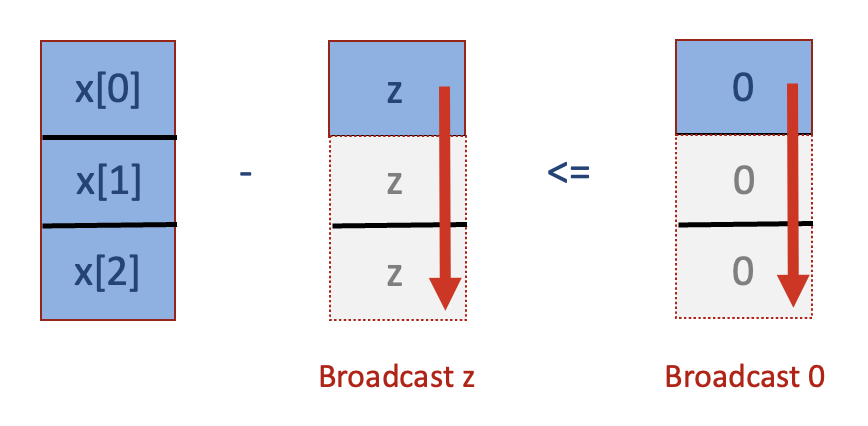
</div>

In [28]:
x = model.addMVar((3,), name="x")
y = model.addMVar((1,1), name="y")
model.update()
le = x + y
print(le)

<MLinExpr (1, 3)  >
array([[ x[0] + y[0,0],  x[1] + y[0,0],  x[2] + y[0,0]]])


In [29]:
X = model.addMVar((2,2), name="X")
Y = model.addMVar((2,), name="Y")
model.update()
qe = X * Y  # Y is broadcast along first axis
print(qe)

<MQuadExpr (2, 2)>
array([[ 0.0 + [ X[0,0] * Y[0] ],  0.0 + [ X[0,1] * Y[1] ]],
       [ 0.0 + [ X[1,0] * Y[0] ],  0.0 + [ X[1,1] * Y[1] ]]])


In [30]:
X = model.addMVar((2,2), name="X")
Y = model.addMVar((2,), name="Y")
model.update()
qe = X * Y[:,np.newaxis] # Y is broadcast along second axis
print(qe)

<MQuadExpr (2, 2)>
array([[ 0.0 + [ X[0,0] * Y[0] ],  0.0 + [ X[0,1] * Y[0] ]],
       [ 0.0 + [ X[1,0] * Y[1] ],  0.0 + [ X[1,1] * Y[1] ]]])


- Primer on broadcasting: https://numpy.org/doc/1.23/user/basics.broadcasting.html
- All of MVar, MLinExpr, MQuadExpr support broadcasting!

## Performance best practice

- All operations in the matrix friendly API have been carefully implemented, considering performance at all times
- Still some patterns will always be faster than others
- **Don't obfuscate your application code for 0.5% performance improvements!**

### Use inplace operations to avoid intermediate copies

- Python's operator dispatch follows left-to-right, applying binary operators one-by-one
- Results in intermediate copies of memory-hungry objects

In [31]:
X = model.addMVar((100,100), name="X")
Y = model.addMVar((100,100), name="Y")
Z = model.addMVar((100,100), name="Z")
expr = 2 * X - 4 * Y + Z

```
+--------------------------------+
| +------------------------+     |        Intermediate
| | +-------+    +-------+ | <---+------- not needed!
| | | 2 * X |  - | 4 * Y | | + Z |
| | +-------+    +-------+ |     |
| +------------------------+     |
+--------------------------------+
```

- Each box represents one memory-hungry object, allocation and de-allocation done by Python automatically
- How to avoid unnecessary intermediate objects?
- Use in-place ops...

In [32]:
X, Y, Z = (model.addMVar((100,100)) for _ in range(3))
expr = 2 * X
expr += -4 * Y
expr += Z

But `2 * X - 4 * Y + Z` reads much nicer...

### Prefer data-data operations when building expressions

- Binary operations among ndarrays are mapped directly to low-level floating point ops (very cheap)
- Binary operations with MVar, MLinExpr, MQuadExpr result in Python object modifications (expensive)
- When possible, assemble data _before_ combining with matrix friendly objects

In [33]:
A = np.random.rand(50, 50)
B = np.random.rand(50, 50)
X = model.addMVar((50, 50))
expr = X @ A @ B

/var/folders/zr/mfd4lbk96gs5r6c454z8pr_h0000gn/T/ipykernel_371/2290949318.py:4: RuntimeWarning: Chained matrix multiplications of MVars is inefficient, collect numeric terms first when building expressions
  expr = X @ A @ B


Python processes `X @ A @ B` as follows:
1. Compute `tmp = X @ A` (expensive)
2. Compute `res = tmp @ B` (super expensive, avoidable) 

Instead: Write `X @ (A @ B)`, which is processed as follows:
1. Compute `tmp = A @ B` (cheap)
2. Compute `res = X @ tmp` (expensive, unavoidable)

## Summary

- Use MVar, MLinExpr, MQuadExpr to model constraints that are naturally expressed in "vectorized" form
- Often allows to write compact, loopless code
- Most arithmetic operations allow for ndarray and scipy.sparse operands
- Accessing Gurobi attributes yield ndarrays

# This is it, thanks!

Time for Q&A!